In [298]:
#https://nilearn.github.io/dev/glm/second_level_model.html
# Reminder : Multiple comparisons correction

import os
import glob
import nilearn 
import itertools
import numpy as np 
import pandas as pd
import nibabel as nib

from scipy.stats import norm
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.datasets import fetch_localizer_contrasts
from nilearn.image import get_data, math_img
from nilearn import plotting, image, datasets
from nilearn.glm.second_level import non_parametric_inference
from nilearn.glm import threshold_stats_img

# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
z_scores_path = "/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/z_score/"
beta_path = "/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/beta_estimates/"


# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'

# Paths for the directories
output_dir = '/project/4180000.19/multirat_stim/rabies_test/second_level_analysis/'
image_dir = os.path.join(output_dir, 'image/')
z_score_dir = os.path.join(output_dir, 'z_score/')
beta_dir = os.path.join(output_dir, 'beta_estimates/')
p_value_dir = os.path.join(output_dir, 'p_value/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(z_score_dir):
    os.makedirs(z_score_dir)
if not os.path.exists(beta_dir):
    os.makedirs(beta_dir)
if not os.path.exists(p_value_dir):
    os.makedirs(p_value_dir)
    
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]


In [284]:
ID = "0"+str(2000+3)
dataset = glob.glob(beta_path+'beta_sub-{}??_ses-1.nii.gz'.format(ID))

print(ID)
print(dataset)

02003
['/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/beta_estimates/beta_sub-0200300_ses-1.nii.gz', '/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/beta_estimates/beta_sub-0200301_ses-1.nii.gz', '/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/beta_estimates/beta_sub-0200304_ses-1.nii.gz', '/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/beta_estimates/beta_sub-0200305_ses-1.nii.gz', '/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/beta_estimates/beta_sub-0200306_ses-1.nii.gz']


7


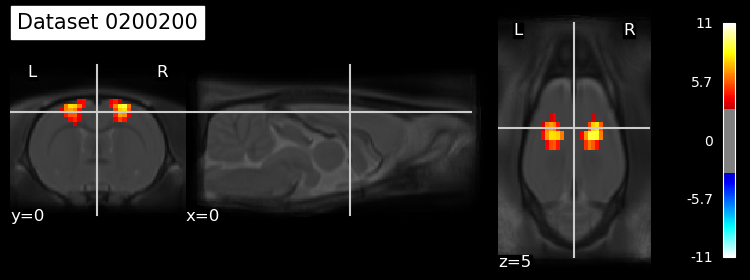

5


<Figure size 640x480 with 0 Axes>

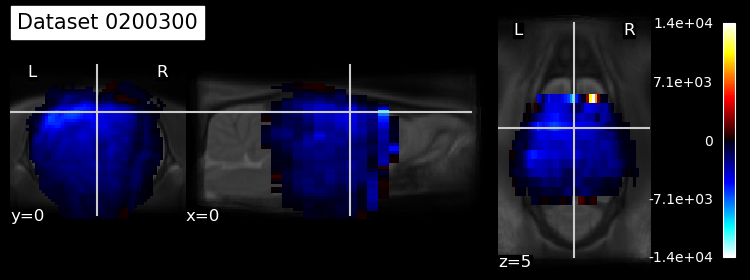

<Figure size 640x480 with 0 Axes>

In [307]:
#https://nilearn.github.io/dev/auto_examples/07_advanced/plot_bids_analysis.html 

for index in range(2, 4):
    
    ID = "0"+str(2000+index) 
    dataset = glob.glob(beta_path+'beta_sub-{}??_ses-1.nii.gz'.format(ID))
    

    n_subject = len(dataset)                                                           
    print(n_subject)

    second_level_input = dataset
    design_matrix = pd.DataFrame([1] * len(second_level_input), 
                                columns=["intercept"])


    # --- Specify the model and fit it --- 
    second_level_model = SecondLevelModel(smoothing_fwhm=0.5,
                                        minimize_memory=False)        #if want to get residuals

    second_level_model = second_level_model.fit(second_level_input,
                                                design_matrix=design_matrix)


    # --- Estimate the contrast --- 
    second_stat_map = second_level_model.compute_contrast(second_level_contrast='intercept', output_type='all') 

    nib.save(second_stat_map['z_score'], z_score_dir+'z_score_sub-{}_ses-1.nii.gz'.format(ID))          #save z_score map
    nib.save(second_stat_map['effect_size'], beta_dir+'beta_sub-{}_ses-1.nii.gz'.format(ID))            #save the beta estimates
    nib.save(second_stat_map['p_value'], p_value_dir+'p_value_sub-{}_ses-1.nii.gz'.format(ID))            #save the p_value

    # # --- Bonferronie correction --- 
    # threshold_uncorrected = 0.001
    # threshold_corrected = threshold_uncorrected / n_subject   #use as input for argument "threshold" when plotting



    p_val = 0.001
    p_unc = norm.isf(p_val)
    plot_stat = plotting.plot_stat_map(second_stat_map['effect_size'],
                                        bg_img = template_path,
                                        threshold = p_unc,              #if plot p_value change to threshold = 0.001
                                        cut_coords= (0 ,0, 5.5),
                                        display_mode='ortho',
                                        draw_cross=True,
                                        colorbar=True,
                                        title="Dataset {}00".format(ID))

    plotting.show()
    plt.savefig(image_dir+'stat_map_sub-{}_ses-1_effect_size.png'.format(ID)) 
